# Effect of Different Block Sizes on Compression with Zstd and SquashFS

### Notebook Configurations

_Imports_

In [1]:
import os
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

_Matplotlib Figures Styles_

In [2]:
plt.rcParams['figure.figsize'] = (11, 8) # for the size of matplotlib plots
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = "y"
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['grid.color'] = "#EEEEEE"

### Initial Hyphotesis

Small block sizes can provide fast compression speeds, but they negatively affect the compression ratio and decompression speed. This is the contrary for big block sizes, however, in the case of filesystems having big blocks mean that a lot of data will be decompressed even if just a small portion of the information wants to be accessed.

Dictionary compression can provide a good workaround that balances compression ratio and decompression speed in the case of small blocks.

### Initial variables

In the use case of a read-only filesystem (such as SquashFS), the decompression latency is a lot more important than compression latency. Thus, a high compression level for Zstd, which envolves slower compression speed but higher ratios and faster decompression, is optimal. 

For this tests, the next files are used:
* __The Canterbury Corpus__: a collection of 11 files, selected as "average documents" from 11 classes of documents. _Total size of dir:_ 2.68 MB
* __enwik8__: database based on Wikipedia composed of mostly english text in XML encoded with UTF-8. _Total size of file:_ 100 MB
* __enwik9__: similar to enwik8, but larger. _Total size of file:_ 1 GB
* __webster.json__: Webster's English Dictionary in JSON format. _Total size of file:_ 23 MB

In [3]:
files = list(os.popen("ls -I '*.ipynb' -I '*.sh'").read().split("\n"))[:-1] # all files in the same directory
files

['cantrbry', 'enwik8', 'enwik9', 'webster.json']

In [9]:
compression_level = 19 # high compression level for Zstandard (max is 22)

_Helper functions_

In [5]:
def get_file_size(file):
    
    is_directory = os.popen(f"./is_directory.sh {file}").read().strip() # shell file to check if string corresponds to dir or file
    
    if(is_directory == "1"):
        size = os.popen(f"du -b {file}").read().split("\t")[0]
    else:
        size = os.popen(f"ls -l {file}").read().split(" ")[4]
    
    return int(size)


def get_speed(size, time):
    
    size_in_mb = size / (1024*1024)
    
    return round((size_in_mb/time), 2)


def get_compression_ratio(original, new):
    return original / new


## Effect of block sizes on compression ratio, compression speed and decompression speed

The following code calculates the three metrics for each file in the directory using 5 different block sizes. 
SquashFS images are created using _zstd_ as the compressor. 

__Example Compression:__ _mksquashfs FILE FILE.sqsh -comp zstd -Xcompression-level 19 -b BLOCKSIZE_

In [10]:
%%capture

block_sizes = ["4K", "16K", "64K", "256K", "1M"] # different block sizes, powers of 4

# New DataFrame
df_19 = pd.DataFrame()
df_19["block_size"] = block_sizes

for file in files:
    
    filename = file.split(".")[0] 
    size_original = get_file_size(file)
    
    # Creation of temporary DF (it stores the data for an specific file)
    file_df = pd.DataFrame(
        columns=["block_size", 
                 f"compression_ratio_{filename}",
                 f"compression_speed_{filename}",
                 f"decompression_speed_{filename}"]
    )

    for size in block_sizes:
        
        # COMPRESSION PROCESS
        new_file = f"{filename}-{size}"

        compression_command = f"mksquashfs {file} {new_file}.sqsh -comp zstd -Xcompression-level {compression_level} -b {size}"

        # Compress and calculate time
        start_time = time.time()
        os.system(compression_command)
        compression_time = time.time() - start_time

        size_new = get_file_size(f"{new_file}.sqsh")

        # Calc metrics
        compression_ratio = get_compression_ratio(size_original, size_new)
        compression_speed = get_speed(size_original, compression_time)

        # DECOMPRESSION PROCESS
        decompression_command = f"unsquashfs -d {new_file} -no-xattrs {new_file}.sqsh"

        # Calc decompression speed
        start_time = time.time()
        os.system(decompression_command)
        decompression_time = time.time() - start_time

        decompression_speed = get_speed(size_new, decompression_time)

        # Addition of row to temporary DF 
        file_df = file_df.append({
            "block_size": size,
            f"compression_ratio_{filename}": compression_ratio,
            f"compression_speed_{filename}": compression_speed,
            f"decompression_speed_{filename}": decompression_speed
        }, ignore_index=True)
    
    # Left merge with main DataFrame (DFs for each file are considered columns of this)
    df_19 = pd.merge(df_19, file_df, how="left", left_on="block_size", right_on="block_size")
    
    os.system(f"ls | grep {filename}- | xargs rm -R") # Code to remove the created files 

Parallel mksquashfs: Using 16 processors
Creating 4.0 filesystem on cantrbry-4K.sqsh, block size 4096.
[===============================================================|] 693/693 100%

Exportable Squashfs 4.0 filesystem, zstd compressed, data block size 4096
	compressed data, compressed metadata, compressed fragments,
	compressed xattrs, compressed ids
	duplicates are removed
Filesystem size 794.45 Kbytes (0.78 Mbytes)
	28.90% of uncompressed filesystem size (2748.77 Kbytes)
Inode table size 1515 bytes (1.48 Kbytes)
	44.22% of uncompressed inode table size (3426 bytes)
Directory table size 179 bytes (0.17 Kbytes)
	90.40% of uncompressed directory table size (198 bytes)
Xattr table size 54 bytes (0.05 Kbytes)
	100.00% of uncompressed xattr table size (54 bytes)
Number of duplicate files found 0
Number of inodes 12
Number of files 11
Number of fragments 1
Number of symbolic links 0
Number of device nodes 0
Number of fifo nodes 0
Number of socket nodes 0
Number of directories 1
Number of i

Parallel mksquashfs: Using 16 processors
Creating 4.0 filesystem on enwik8-64K.sqsh, block size 65536.
[=============================================================/] 1526/1526 100%

Exportable Squashfs 4.0 filesystem, zstd compressed, data block size 65536
	compressed data, compressed metadata, compressed fragments,
	compressed xattrs, compressed ids
	duplicates are removed
Filesystem size 35395.75 Kbytes (34.57 Mbytes)
	36.24% of uncompressed filesystem size (97662.55 Kbytes)
Inode table size 3462 bytes (3.38 Kbytes)
	55.89% of uncompressed inode table size (6194 bytes)
Directory table size 28 bytes (0.03 Kbytes)
	100.00% of uncompressed directory table size (28 bytes)
Xattr table size 54 bytes (0.05 Kbytes)
	100.00% of uncompressed xattr table size (54 bytes)
Number of duplicate files found 0
Number of inodes 2
Number of files 1
Number of fragments 0
Number of symbolic links 0
Number of device nodes 0
Number of fifo nodes 0
Number of socket nodes 0
Number of directories 1
Number of

Parallel mksquashfs: Using 16 processors
Creating 4.0 filesystem on enwik9-256K.sqsh, block size 262144.
[=============================================================-] 3815/3815 100%

Exportable Squashfs 4.0 filesystem, zstd compressed, data block size 262144
	compressed data, compressed metadata, compressed fragments,
	compressed xattrs, compressed ids
	duplicates are removed
Filesystem size 287068.86 Kbytes (280.34 Mbytes)
	29.40% of uncompressed filesystem size (976577.74 Kbytes)
Inode table size 10250 bytes (10.01 Kbytes)
	66.77% of uncompressed inode table size (15352 bytes)
Directory table size 28 bytes (0.03 Kbytes)
	100.00% of uncompressed directory table size (28 bytes)
Xattr table size 54 bytes (0.05 Kbytes)
	100.00% of uncompressed xattr table size (54 bytes)
Number of duplicate files found 0
Number of inodes 2
Number of files 1
Number of fragments 0
Number of symbolic links 0
Number of device nodes 0
Number of fifo nodes 0
Number of socket nodes 0
Number of directories 1


[=================================================================-] 22/22 100%

Exportable Squashfs 4.0 filesystem, zstd compressed, data block size 1048576
	compressed data, compressed metadata, compressed fragments,
	compressed xattrs, compressed ids
	duplicates are removed
Filesystem size 7259.53 Kbytes (7.09 Mbytes)
	32.36% of uncompressed filesystem size (22432.09 Kbytes)
Inode table size 143 bytes (0.14 Kbytes)
	80.34% of uncompressed inode table size (178 bytes)
Directory table size 34 bytes (0.03 Kbytes)
	100.00% of uncompressed directory table size (34 bytes)
Xattr table size 54 bytes (0.05 Kbytes)
	100.00% of uncompressed xattr table size (54 bytes)
Number of duplicate files found 0
Number of inodes 2
Number of files 1
Number of fragments 0
Number of symbolic links 0
Number of device nodes 0
Number of fifo nodes 0
Number of socket nodes 0
Number of directories 1
Number of ids (unique uids + gids) 1
Number of uids 1
	carloscrg19 (1000)
Number of gids 1
	carloscrg19 (1000)
Par

### Results

The obtained data stored in the main DataFrame.

In [13]:
df_19

,block_size,compression_ratio_cantrbry,compression_speed_cantrbry,decompression_speed_cantrbry,compression_ratio_enwik8,compression_speed_enwik8,decompression_speed_enwik8,compression_ratio_enwik9,compression_speed_enwik9,decompression_speed_enwik9,compression_ratio_webster,compression_speed_webster,decompression_speed_webster
0,4K,3.453400,26.94,85.10,2.173230,52.89,322.23,2.255570,47.64,335.52,2.063250,47.69,288.32
1,16K,4.165009,22.19,101.45,2.486410,43.06,471.60,2.734336,35.14,475.84,2.318278,36.52,298.83
2,64K,4.612259,16.32,76.54,2.758963,27.19,424.46,3.103864,24.24,459.11,2.563032,22.13,347.14
3,256K,5.128556,9.60,75.81,3.000745,24.50,433.07,3.401803,21.83,413.49,2.822302,17.06,334.69
4,1M,5.368958,5.18,55.29,3.231511,20.57,395.38,3.673055,19.82,370.43,3.089760,13.13,276.68


Creation of main graph. 

/tmp/ipykernel_22858/466241251.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax1, ax2, ax3],


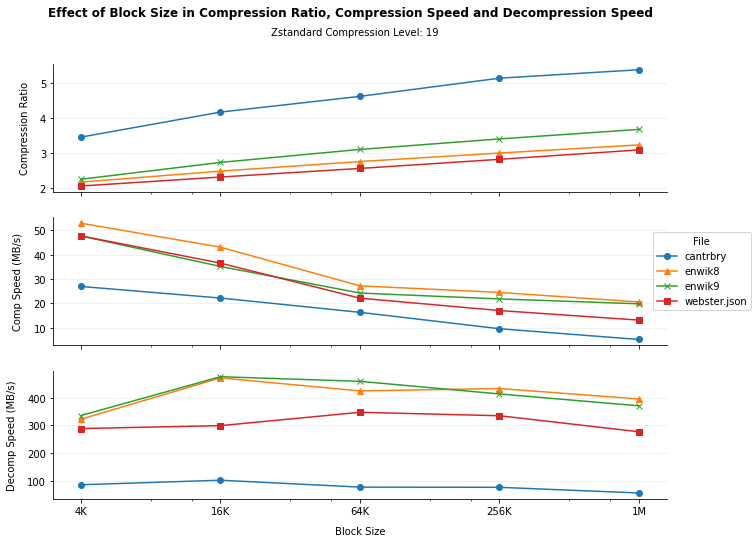

In [14]:
# GRAPH IMPLEMENTED WITH MATPLOTLIB SUBPLOTS

# Creation of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
fig.suptitle("Effect of Block Size in Compression Ratio, Compression Speed and Decompression Speed", weight="bold")
fig.text(s="Zstandard Compression Level: 19", y=0.93, x=0.4)

markers = ["o", "^", "x", "s", "."] # Possible markers to differentiate the plots for each file (allows for 5 different files)

columns = ["compression_ratio", "compression_speed", "decompression_speed"] 
x = [pow(4,i) for i in range(1, 6)] # Array for ticks in X axis 

for (i, file) in enumerate(files):
    
    filename = file.split(".")[0] # Name of file w/o fileformat
    
    # semilogx is used for these plots as it allows a logaritmic
    # progression in the x axis. Block sizes are selected following a progression of base 4
    ax1.semilogx(x, df_19[f"compression_ratio_{filename}"], label=file, base=4, marker=markers[i])
    ax2.semilogx(x, df_19[f"compression_speed_{filename}"], label=file, base=4, marker=markers[i])
    ax3.semilogx(x, df_19[f"decompression_speed_{filename}"], label=file, base=4, marker=markers[i])

# AXES STYLES

# Y axis
ax1.set_ylabel("Compression Ratio", labelpad=10)
ax2.set_ylabel("Comp Speed (MB/s)", labelpad=10)
ax3.set_ylabel("Decomp Speed (MB/s)", labelpad=10)

# X axis
ax3.set_xlabel("Block Size", labelpad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(block_sizes)
    
# Labels to identify each file
fig.legend([ax1, ax2, ax3],
           labels=files,      
           loc="center right",
           borderaxespad=0.1,
           title="File"
          )
    
plt.show()

Average of each metric.

In [15]:
n_files = len(files)
n_blocks = len(block_sizes)

compression_ratios = np.zeros(n_blocks)
compression_speeds = np.zeros(n_blocks)
decompression_speeds = np.zeros(n_blocks)

for col in df_19.columns:

    if "compression_ratio" in col:
        compression_ratios += df_19[col]
        
    elif "decompression_speed" in col:
        decompression_speeds += df_19[col]
    
    elif "compression_speed" in col:
        compression_speeds += df_19[col]

df_avg = pd.DataFrame({"block_size": block_sizes,
                       "compression_ratio" : compression_ratios / n_files,
                       "compression_speed": compression_speeds / n_files,
                       "decompression_speed": decompression_speeds / n_files})

df_avg

,block_size,compression_ratio,compression_speed,decompression_speed
0,4K,2.486362,43.7900,257.7925
1,16K,2.926008,34.2275,336.9300
2,64K,3.259529,22.4700,326.8125
3,256K,3.588352,18.2475,314.2650
4,1M,3.840821,14.6750,274.4450


Average compression speed.

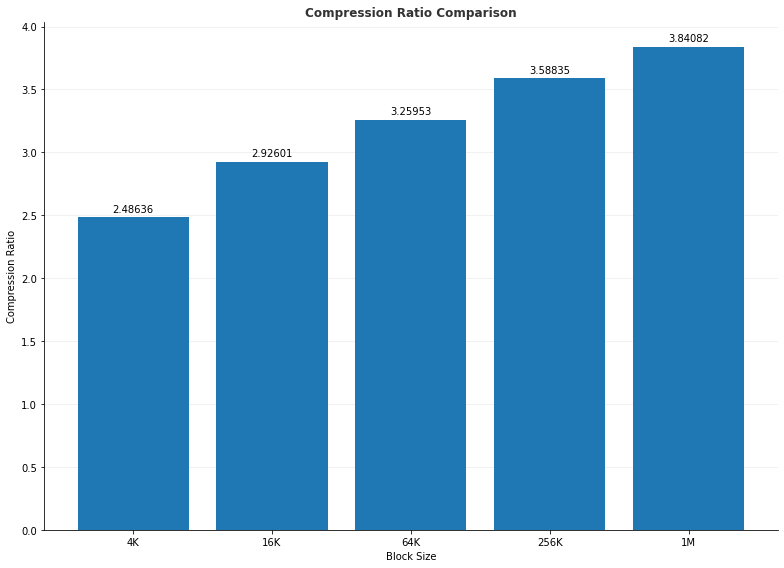

In [16]:
fig, ax = plt.subplots()

compression_ratio_bars = ax.bar(x=df_avg["block_size"], height=df_avg["compression_ratio"])

ax.set_ylabel("Compression Ratio")
ax.set_xlabel("Block Size")
ax.bar_label(compression_ratio_bars, padding=3)

ax.set_title('Compression Ratio Comparison', color='#333333', weight='bold')

fig.tight_layout()
plt.show()

Average Compression Speed.

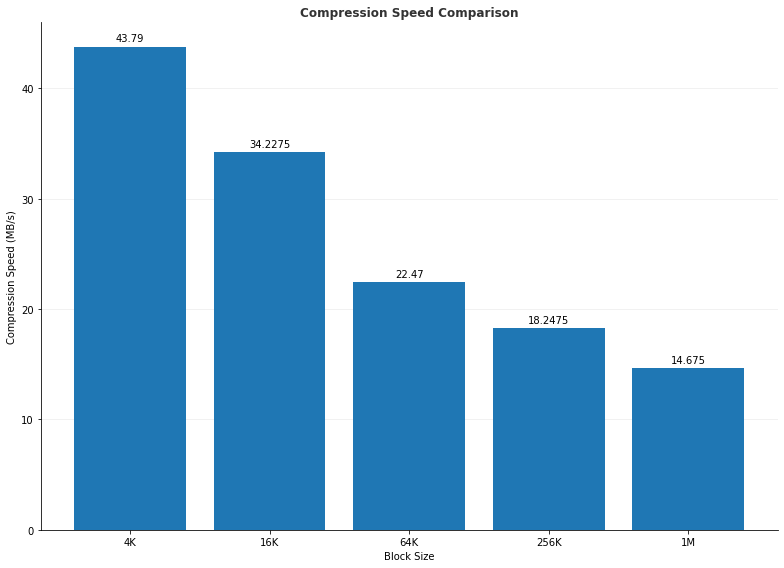

In [17]:
fig, ax = plt.subplots()

compression_ratio_bars = ax.bar(x=df_avg["block_size"], height=df_avg["compression_speed"])

ax.set_ylabel("Compression Speed (MB/s)")
ax.set_xlabel("Block Size")
ax.bar_label(compression_ratio_bars, padding=3)

ax.set_title('Compression Speed Comparison', color='#333333', weight='bold')

fig.tight_layout()
plt.show()

Average Decompression Speed.

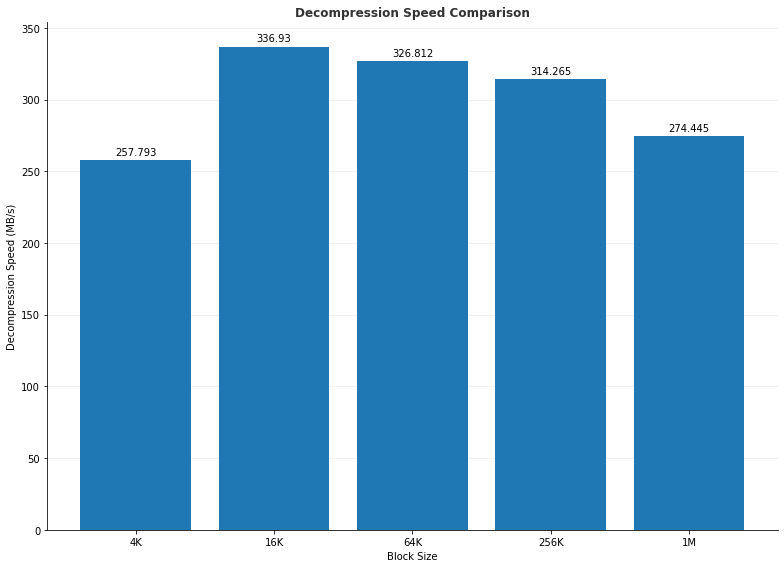

In [18]:
fig, ax = plt.subplots()

compression_ratio_bars = ax.bar(x=df_avg["block_size"], height=df_avg["decompression_speed"])

ax.set_ylabel("Decompression Speed (MB/s)")
ax.set_xlabel("Block Size")
ax.bar_label(compression_ratio_bars, padding=3)

ax.set_title('Decompression Speed Comparison', color='#333333', weight='bold')

fig.tight_layout()
plt.show()

#### Results with lower compression level

To see if this behaviour was the same in different compression scenarios, tests were run again using 7 as the compression level for Zstd.

In [7]:
df_7

,block_size,compression_ratio_cantrbry,compression_speed_cantrbry,decompression_speed_cantrbry,compression_ratio_enwik8,compression_speed_enwik8,decompression_speed_enwik8,compression_ratio_enwik9,compression_speed_enwik9,decompression_speed_enwik9,compression_ratio_webster,compression_speed_webster,decompression_speed_webster
0,4K,3.419038,160.04,91.94,2.143653,481.09,330.29,2.224151,527.62,364.57,2.043701,346.34,305.10
1,16K,4.042509,193.71,120.60,2.430711,446.86,414.44,2.674722,497.06,2356.35,2.273172,309.16,417.30
2,64K,4.349535,182.60,97.83,2.657458,341.68,490.06,2.991663,408.15,465.96,2.465017,240.20,368.29
3,256K,4.551169,105.85,97.26,2.834889,166.77,481.21,3.213053,175.13,485.34,2.632824,129.06,380.84
4,1M,4.675011,92.28,75.29,2.967193,125.15,442.80,3.371875,135.48,387.54,2.796965,86.89,283.25


/tmp/ipykernel_22858/3073863729.py:36: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax1, ax2, ax3],


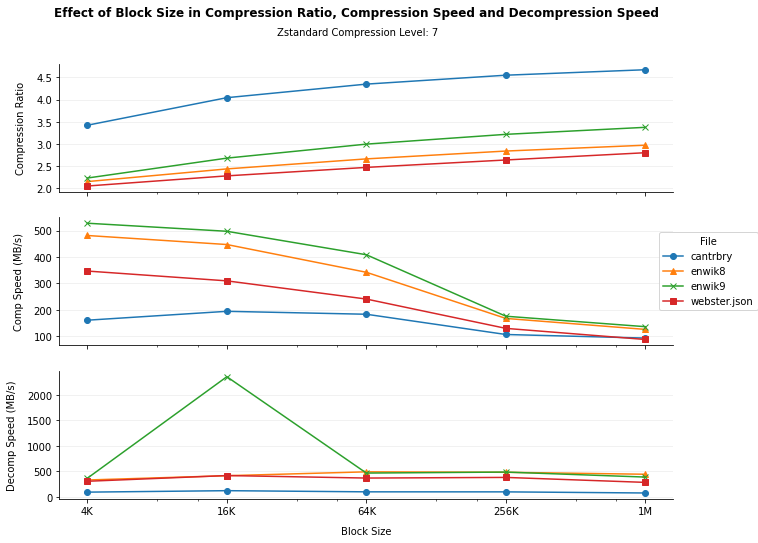

In [8]:
# GRAPH IMPLEMENTED WITH MATPLOTLIB SUBPLOTS

# Creation of subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
fig.suptitle("Effect of Block Size in Compression Ratio, Compression Speed and Decompression Speed", weight="bold")
fig.text(s="Zstandard Compression Level: 7", y=0.93, x=0.4)

markers = ["o", "^", "x", "s", "."] # Possible markers to differentiate the plots for each file (allows for 5 different files)

columns = ["compression_ratio", "compression_speed", "decompression_speed"] 
x = [pow(4,i) for i in range(1, 6)] # Array for ticks in X axis 

for (i, file) in enumerate(files):
    
    filename = file.split(".")[0] # Name of file w/o fileformat
    
    # semilogx is used for these plots as it allows a logaritmic
    # progression in the x axis. Block sizes are selected following a progression of base 4
    ax1.semilogx(x, df_7[f"compression_ratio_{filename}"], label=file, base=4, marker=markers[i])
    ax2.semilogx(x, df_7[f"compression_speed_{filename}"], label=file, base=4, marker=markers[i])
    ax3.semilogx(x, df_7[f"decompression_speed_{filename}"], label=file, base=4, marker=markers[i])

# AXES STYLES

# Y axis
ax1.set_ylabel("Compression Ratio", labelpad=10)
ax2.set_ylabel("Comp Speed (MB/s)", labelpad=10)
ax3.set_ylabel("Decomp Speed (MB/s)", labelpad=10)

# X axis
ax3.set_xlabel("Block Size", labelpad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(block_sizes)
    
# Labels to identify each file
fig.legend([ax1, ax2, ax3],
           labels=files,      
           loc="center right",
           borderaxespad=0.1,
           title="File"
          )
    
plt.show()

### Insights

* It is clear that with the increase in block size, a higher compression ratio is achieved. This is good since we use less space to store the compressed file...but it has its disadvantages
* Compression Speed severely decreases with the increase in block size. For both compression levels, the most significant decrease occurs between 16K and 64K. With 19 as Compression Level, in average, this decrease corresponds to 12 MB/s. 
* Decompression Speed gets higher with a bigger block size, however, it becomes slower after certain size. For the 19 level, the best performance was achieved with 16K, since in average it improved in 79 MB/s from the previous 4K size. After this, the speed started decreasing and the largest and shortest block size even had similar metrics.
* In general, the best performance in terms of balance between the three metrics was the 16K size, it was the fastest for decompression, the second best for compression speed and offered decent compression ratio. __Improving this last metric can be a good opportunity for Dictionary Compression__ since it is still a small size for which the virtues of this technique can be exploided. 